In [1]:
import random
import math
from collections import namedtuple, deque
from itertools import count

import matplotlib
import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
import torch
from torch import optim
from torch import nn

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper

In [2]:
unity_env = UnityEnvironment("C:/Users/Pawel/Microbe_Simulation/Builds/Microbe_Simulation.exe")
env = UnityToGymWrapper(unity_env, allow_multiple_obs=True)

In [3]:
from model import DQN

In [4]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu"
)

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.01
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()[0]
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0
episode_durations = []
episode_rewards = []

In [7]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [8]:
def plot_durations(show_result=False):
    fig, ax = plt.subplots()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        ax.set_title('Result')
    else:
        ax.clear()
        ax.set_title('Training...')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Duration')
    ax.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(fig)
            display.clear_output(wait=True)
        else:
            display.display(fig)

In [9]:
def plot_rewards(show_result=False):
    fig, ax = plt.subplots()
    rewards = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        ax.set_title('Result')
    else:
        ax.clear()
        ax.set_title('Training...')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Rewards')
    ax.plot(rewards.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards) >= 100:
        means = rewards.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(fig)
            display.clear_output(wait=True)
        else:
            display.display(fig)

In [10]:
def plot_both(show_result=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    rewards = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        axs[0].set_title('Result')
        axs[1].set_title('Result')
    else:
        axs[0].clear()
        axs[1].clear()
        axs[0].set_title('Training...')
        axs[1].set_title('Training...')
    axs[0].set_xlabel('Episode')
    axs[1].set_xlabel('Episode')
    axs[0].set_ylabel('Duration')
    axs[1].set_ylabel('Reward')
    
    axs[0].plot(durations_t.numpy())
    axs[1].plot(rewards.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means_dur = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means_dur = torch.cat((torch.zeros(99), means_dur))
        axs[0].plot(means_dur.numpy())
        
        means_rew = rewards.unfold(0, 100, 1).mean(1).view(-1)
        means_rew = torch.cat((torch.zeros(99), means_rew))
        axs[1].plot(means_rew.numpy())

    plt.pause(0.005)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(fig)
            display.clear_output(wait=True)
        else:
            display.display(fig)

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


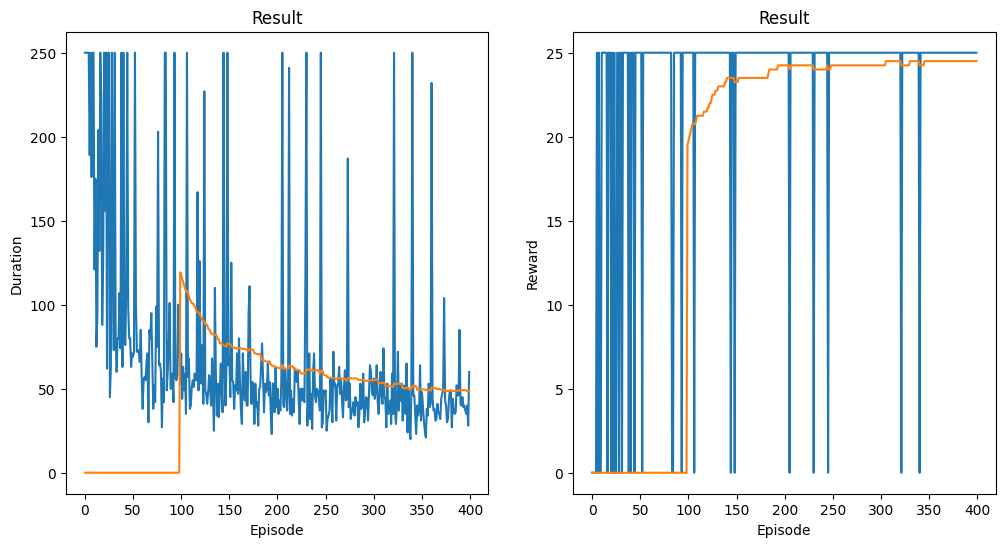

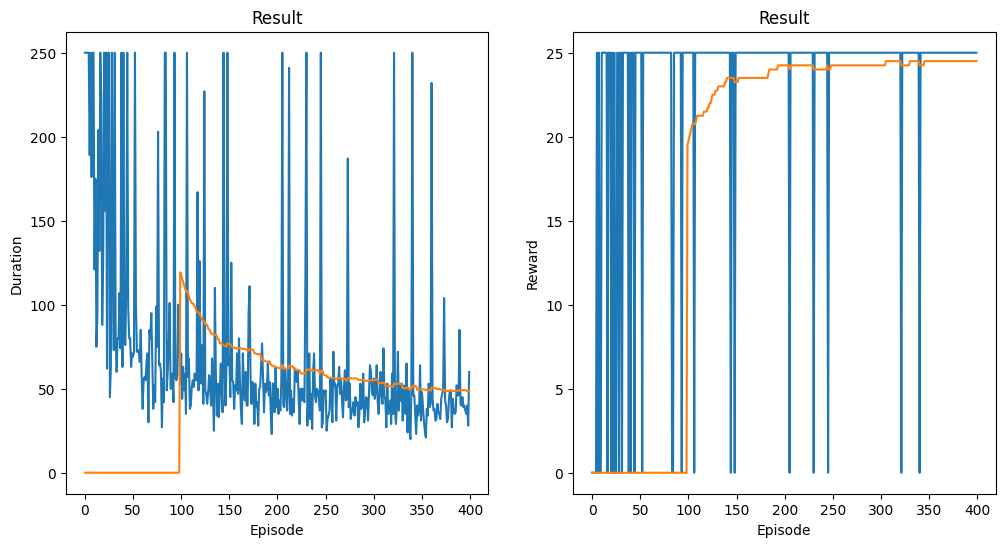

In [12]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 400
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)#.unsqueeze(0)
    
    t = 0
    while True:
        action = select_action(state)
        #observation, reward, terminated, truncated = env.step(action.item())
        observation, reward, episodeEnded, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if episodeEnded:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)#.unsqueeze(0)
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if episodeEnded:
            episode_durations.append(t + 1)
            episode_rewards.append(reward.item())
            plot_both()
            
            # plot_durations()
            # plot_rewards()
            break
        
        t += 1


print('Complete')
plot_both(show_result=True)
# plot_durations(show_result=True)
# plot_rewards(show_result=True)

plt.ioff()
plt.show()

In [13]:
episode_rewards

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 25.0,
 0.0,
 25.0,
 0.0,
 0.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 0.0,
 25.0,
 25.0,
 25.0,
 0.0,
 25.0,
 0.0,
 25.0,
 0.0,
 0.0,
 25.0,
 25.0,
 0.0,
 25.0,
 25.0,
 0.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 0.0,
 25.0,
 0.0,
 25.0,
 25.0,
 25.0,
 0.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 0.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 0.0,
 0.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 0.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 0.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 0.0,
 25.0,
 2